# Disease Prediction from Medical Data

# Import Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

Data Set Read


In [3]:
df = pd.read_csv('/content/heart.csv.csv')


In [5]:
df.head(30)

,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0
5,6,56,Male,Cleveland,atypical angina,120.0,236.0,False,normal,178.0,False,0.8,upsloping,0.0,normal,0
6,7,62,Female,Cleveland,asymptomatic,140.0,268.0,False,lv hypertrophy,160.0,False,3.6,downsloping,2.0,normal,3
7,8,57,Female,Cleveland,asymptomatic,120.0,354.0,False,normal,163.0,True,0.6,upsloping,0.0,normal,0
8,9,63,Male,Cleveland,asymptomatic,130.0,254.0,False,lv hypertrophy,147.0,False,1.4,flat,1.0,reversable defect,2
9,10,53,Male,Cleveland,asymptomatic,140.0,203.0,True,lv hypertrophy,155.0,True,3.1,downsloping,0.0,reversable defect,1


Drop

In [6]:
df = df.drop(columns=['id', 'dataset'])

Target Variable

In [7]:
df['num'] = df['num'].apply(lambda x: 1 if x > 0 else 0)
y = df['num']

Categorical to String

In [8]:
categorical_cols = df.select_dtypes(include='object').columns.tolist()

In [9]:
df['fbs'] = df['fbs'].map({True: 1, False: 0})
df['exang'] = df['exang'].map({True: 1, False: 0})

Rest of Column

In [10]:
df_encoded = pd.get_dummies(df, columns=['sex', 'cp', 'restecg', 'slope', 'thal'], drop_first=True, dtype=int)

Numerical Column

In [11]:
numerical_cols = ['age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'ca']
features = df_encoded.drop(columns=['num']).columns

X = df_encoded.drop(columns=['num'])

Encoding

In [12]:
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)
X_imputed['ca'] = X_imputed['ca'].apply(lambda x: 1 if x > 0 and x < 1 else round(x))

Train and Test

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42, stratify=y)

#  (Data Scaling)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#  (Handling Class Imbalance) - SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_scaled, y_train)

Grid Cv

In [14]:
# XGBoost
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.05, 0.1]
}

xgb_grid_search = GridSearchCV(estimator=xgb_model, param_grid=xgb_param_grid, cv=5, scoring='accuracy', n_jobs=-1)
xgb_grid_search.fit(X_train_res, y_train_res)
best_xgb_model = xgb_grid_search.best_estimator_

#(Evaluation)
xgb_pred = best_xgb_model.predict(X_test_scaled)
xgb_accuracy = accuracy_score(y_test, xgb_pred)
xgb_roc_auc = roc_auc_score(y_test, best_xgb_model.predict_proba(X_test_scaled)[:, 1])

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [08:10:30] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [17]:
from sklearn.metrics import accuracy_score

# (XGBoost)
xgb_accuracy = accuracy_score(y_test, xgb_pred)
print(f"Test Accuracy: {xgb_accuracy:.3f}")


Test Accuracy: 0.826


In [15]:
# Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5]
}

rf_grid_search = GridSearchCV(estimator=rf_model, param_grid=rf_param_grid, cv=5, scoring='accuracy', n_jobs=-1)
rf_grid_search.fit(X_train_res, y_train_res)
best_rf_model = rf_grid_search.best_estimator_

#  (Evaluation)
rf_pred = best_rf_model.predict(X_test_scaled)
rf_accuracy = accuracy_score(y_test, rf_pred)
rf_roc_auc = roc_auc_score(y_test, best_rf_model.predict_proba(X_test_scaled)[:, 1])

In [20]:
from sklearn.metrics import accuracy_score

# (RF)
rf_accuracy = accuracy_score(y_test, rf_pred)
print(f"Test Accuracy: {rf_accuracy:.3f}")

Test Accuracy: 0.853


In [16]:
# Logistic Regression (Standard Model)
lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train_res, y_train_res)

#  (Evaluation)
lr_pred = lr_model.predict(X_test_scaled)
lr_accuracy = accuracy_score(y_test, lr_pred)
lr_roc_auc = roc_auc_score(y_test, lr_model.predict_proba(X_test_scaled)[:, 1])

In [21]:
from sklearn.metrics import accuracy_score

# (LR)
lr_accuracy = accuracy_score(y_test, lr_pred)
print(f"Test Accuracy: {lr_accuracy:.3f}")

Test Accuracy: 0.815


In [23]:
print("==============================================")
print("             Final Model: RF             ")
print("==============================================")
print(f"Test Accuracy: {rf_accuracy:.3f}")
print(f"AUC-ROC Score: {rf_roc_auc:.3f}")
print("\nClassification Report (rf):")
print(classification_report(y_test, rf_pred))

             Final Model: RF             
Test Accuracy: 0.853
AUC-ROC Score: 0.912

Classification Report (rf):
              precision    recall  f1-score   support

           0       0.86      0.80      0.83        82
           1       0.85      0.89      0.87       102

    accuracy                           0.85       184
   macro avg       0.85      0.85      0.85       184
weighted avg       0.85      0.85      0.85       184



Best Model

In [24]:
#  (Saving the Best Model)
joblib.dump(best_xgb_model, 'best_disease_prediction_model.pkl')

#  (Saving the Scaler)

joblib.dump(scaler, 'scaler_for_prediction.pkl')

print("Mmodel and Scaler successfully saved!")

Mmodel and Scaler successfully saved!


# Plot

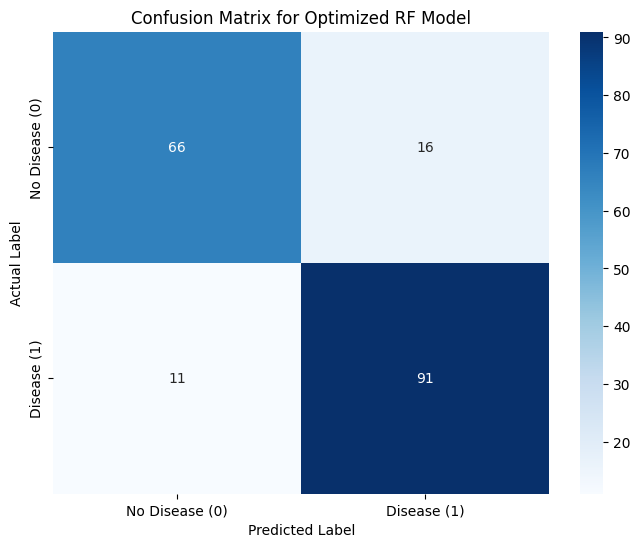

In [25]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# RF
rf_pred = best_rf_model.predict(X_test_scaled)
cm = confusion_matrix(y_test, rf_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Disease (0)', 'Disease (1)'],
            yticklabels=['No Disease (0)', 'Disease (1)'])
plt.title('Confusion Matrix for Optimized RF Model')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

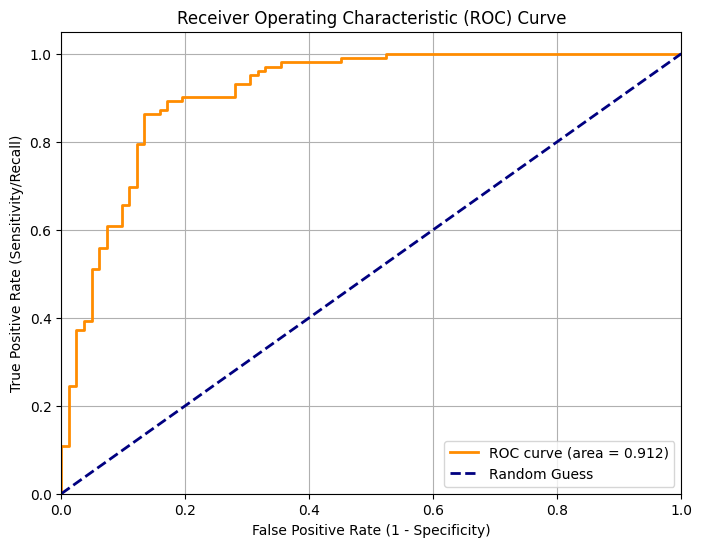

In [26]:
# ROC Curve
from sklearn.metrics import roc_curve, auc

# (Prediction Probabilities)
rf_probs = best_rf_model.predict_proba(X_test_scaled)[:, 1]

# ROC
fpr, tpr, thresholds = roc_curve(y_test, rf_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label=f'ROC curve (area = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity/Recall)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

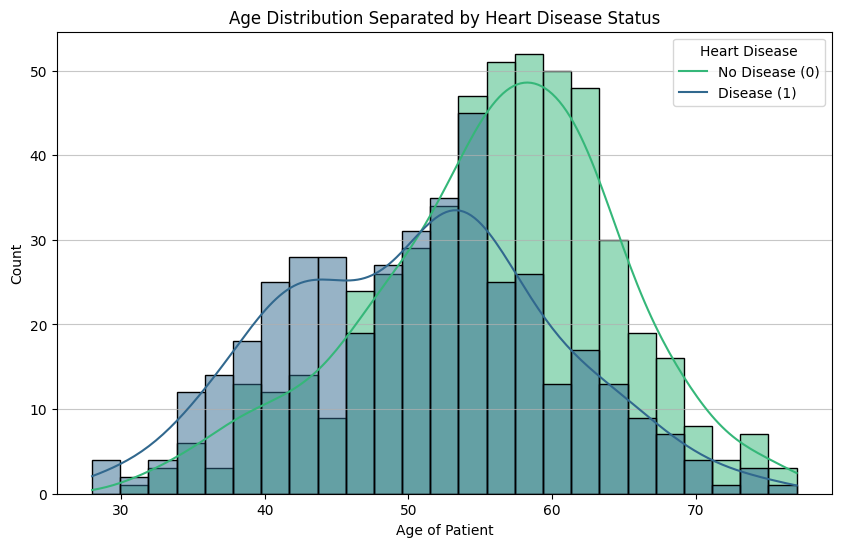

In [27]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='age', hue='num', kde=True, bins=25, palette='viridis')
plt.title('Age Distribution Separated by Heart Disease Status')
plt.xlabel('Age of Patient')
plt.ylabel('Count')
plt.legend(title='Heart Disease', labels=['No Disease (0)', 'Disease (1)'])
plt.grid(axis='y', alpha=0.7)
plt.show()

Output

In [29]:
# Load the saved model and scaler
best_model = joblib.load('best_disease_prediction_model.pkl')
scaler_loaded = joblib.load('scaler_for_prediction.pkl')

# Re-fit a SimpleImputer for 'ca' based on the mean of the original 'ca' column
original_df = pd.read_csv('/content/heart.csv.csv') # Load original data to get mean of 'ca'
original_df['num'] = original_df['num'].apply(lambda x: 1 if x > 0 else 0) # Apply same target binarization
original_df = original_df.drop(columns=['id', 'dataset']) # Drop same columns

# Handle True/False columns before imputation
original_df['fbs'] = original_df['fbs'].map({True: 1, False: 0})
original_df['exang'] = original_df['exang'].map({True: 1, False: 0})

# Apply One-Hot Encoding to the original data to get the correct columns for the imputer fit
categorical_cols = ['sex', 'cp', 'restecg', 'slope', 'thal']
original_df_encoded = pd.get_dummies(original_df, columns=categorical_cols, drop_first=True, dtype=int)

# Fit imputer on the original training data (or full data if preferred, consistent with training)
imputer_ca = SimpleImputer(missing_values=np.nan, strategy='mean')
imputer_ca.fit(original_df_encoded[['ca']]) # Fit only on the 'ca' column


# Prediction function
def predict_new_patient(patient_data: dict):
    """
    Predicts heart disease for new patient data.
    """
    # Convert data to pandas DataFrame
    new_df = pd.DataFrame([patient_data])

    # Reapply data processing steps

    # a. Convert True/False columns to numbers
    new_df['fbs'] = new_df['fbs'].map({True: 1, False: 0})
    new_df['exang'] = new_df['exang'].map({True: 1, False: 0})

    # b. One-Hot Encoding (Ensure columns match training data)
    categorical_cols = ['sex', 'cp', 'restecg', 'slope', 'thal']
    new_df_encoded = pd.get_dummies(new_df, columns=categorical_cols, drop_first=True, dtype=int)

    # c. Align columns with training data
    # Get the column names the scaler was fitted on
    training_columns = scaler_loaded.feature_names_in_


    # Add missing columns and ensure order matches training data
    for col in training_columns:
        if col not in new_df_encoded.columns:
            new_df_encoded[col] = 0  # Add missing columns with 0

    # Ensure the order of columns in the new data matches the training data
    new_df_processed = new_df_encoded[training_columns]

    # d. Impute missing values in 'ca' using the fitted imputer
    if 'ca' in new_df_processed.columns and new_df_processed['ca'].isnull().any():
         new_df_processed['ca'] = imputer_ca.transform(new_df_processed[['ca']])


    # e. Scale the data
    new_data_scaled = scaler_loaded.transform(new_df_processed)

    # f. Prediction
    prediction_proba = best_model.predict_proba(new_data_scaled)[0]
    prediction = best_model.predict(new_data_scaled)[0]

    # Interpretation of results
    result = {
        'Prediction': "Heart Disease Present (রোগ আছে)" if prediction == 1 else "No Heart Disease (রোগ নেই)",
        'Probability_Disease': f"{prediction_proba[1]*100:.2f}%",
        'Probability_No_Disease': f"{prediction_proba[0]*100:.2f}%"
    }

    return result

# Example Usage
example_patient_data = {
    'age': 52,
    'sex': 'Female',
    'cp': 'non-anginal pain',
    'trestbps': 10,
    'chol': 20,
    'fbs': True,
    'restecg': 'normal',
    'thalch': 10,
    'exang': False,
    'oldpeak': 0.5,
    'slope': 'flat',
    'ca': 1, # Example with a value
    'thal': 'fixed defect'
}

prediction_result = predict_new_patient(example_patient_data)
print("\n=== New Patient Prediction ===")
print(f"Prediction: {prediction_result['Prediction']}")
print(f"Confidence (Disease): {prediction_result['Probability_Disease']}")
print(f"Confidence (No Disease): {prediction_result['Probability_No_Disease']}")


=== New Patient Prediction ===
Prediction: Heart Disease Present (রোগ আছে)
Confidence (Disease): 81.05%
Confidence (No Disease): 18.95%
